# Differential Loops and TADs

In [1]:
import os
import importlib
import warnings
from collections import Counter
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

from utils.data import DataTree
from utils import out_dire
import snapfish2 as sf
importlib.reload(sf)
dtree = DataTree("../data")

In [2]:
%reload_ext autoreload
%autoreload 2

## Mouse cerebellum (Takei et al, 2025)

In [186]:
loader = sf.pp.FOF_CT_Loader(
    "../data/takei_nature_2025/chr6_49388_50913.csv",
    voxel_ratio={c: 1000 for c in "XYZ"}, obs_cols_add=["Cell_ID"]
)
celldfs = sf.pp.FOF_CT_Loader("../data/takei_nature_2025/cell.csv").read_data()
adata = loader.create_adata("chr6")
sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cell_type")
adata.obs["cell_type"].value_counts()

cell_type
granule            2336
mixture             495
bergmann_glia       458
MLI1                238
purkinje            126
MLI2/PLI             79
endothelial          51
astrocyte            51
oligodendrocyte      23
Name: count, dtype: int64

In [187]:
granule = adata[adata.obs["cell_type"] == "granule"].copy()
granule

AnnData object with n_obs × n_vars = 2336 × 41
    obs: 'Cell_ID', 'cell_type'
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'

In [188]:
# Missing ratio
np.mean(np.isnan(granule.layers["X"]))

0.9316843468092215

In [189]:
np.sum(~np.isnan(granule.layers["X"]), axis=0)

array([ 98,  65, 127, 134, 197, 154, 146, 177, 138, 124, 179, 128, 155,
       183, 188, 102, 157, 203, 162, 182, 156, 203, 140, 208, 114, 191,
       139, 180, 147, 113, 170, 150, 217, 186, 232, 151, 130, 154, 150,
       249, 164])

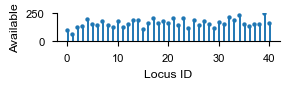

In [190]:
avail_count = np.sum(~np.isnan(granule.layers["X"]), axis=0)
fig, ax = plt.subplots(figsize=(3, 1))
sns.scatterplot(avail_count, linewidth=0, s=10, ax=ax)
ax.vlines(x=np.arange(len(avail_count))+.1, ymin=0, ymax=avail_count)
ax.set(xlabel="Locus ID", ylabel="Available", ylim=(0, 250))
ax.grid(False)

In [191]:
sf.pp.filter_normalize(granule)

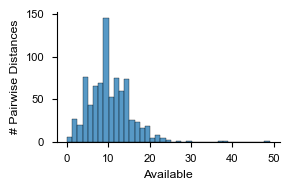

In [192]:
countx = granule.varp["count_X"]
fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(countx[np.triu_indices_from(countx, k=1)], ax=ax)
ax.set(xlabel="Available", ylabel="# Pairwise Distances")
ax.grid(False)

In [ ]:
sf.pp.median_pdist(granule)
fig, ax = plt.subplots(figsize=(2, 2))
sf.pl.pairwise_heatmap(granule.varp["med_dist"], vmax=2000, cbar=False, ax=ax)

## Mouse brain cell types

In [3]:
reps = ["rep1", "rep2", "rep3"]
loader = sf.pp.FOF_CT_Loader({
    c: dtree["takei_science_2021", "25Kb", c] for c in reps
}, voxel_ratio={"X": 1000, "Y": 1000, "Z": 1000}, obs_cols_add=["Cell_ID"])
celldfs = sf.pp.FOF_CT_Loader({
    c: dtree["takei_science_2021", "cell_type", c] for c in reps
}).read_data()
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro',
                 6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}

In [4]:
count_df = []
for chr_id in loader.chr_ids:
    adata = loader.create_adata(chr_id)
    sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
    count_sr = adata.obs["cluster label"].map(celltype_dict)
    count_df.append(count_sr.value_counts().rename(chr_id))
count_df = pd.DataFrame(count_df)
count_df

cluster label,Ex,Astro,Pvalb,Endo,Micro,Oligo,Vip,Sst,Ndnf
chr1,2682,233,221,214,136,98,90,80,60
chr2,2627,238,221,249,129,107,83,74,54
chr6,2635,238,205,198,127,112,83,80,58
chr8,2595,235,223,273,145,115,87,73,55
chr10,2635,206,217,190,135,104,92,80,49
chr13,2569,232,186,226,135,107,78,71,57
chr16,2635,220,213,218,134,105,89,83,49
chr17,2692,241,218,268,139,105,85,75,53
chr3,2514,233,207,264,130,107,90,81,50
chr4,2629,230,227,267,141,114,86,78,47


In [ ]:
count_df.mean()

cluster label
Ex       2646.60
Astro     230.70
Pvalb     213.25
Endo      247.25
Micro     134.90
Oligo     106.15
Vip        86.75
Sst        78.25
Ndnf       54.70
dtype: float64

In [5]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)
sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro',
                 6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}
adata.obs["cell_type"] = adata.obs["cluster label"].map(celltype_dict)

In [6]:
def fetch_adata(chr_id, cell_type):
    adata = loader.create_adata(chr_id)
    sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
    celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro',
                    6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}
    adata.obs["cell_type"] = adata.obs["cluster label"].map(celltype_dict)
    return adata[adata.obs["cell_type"] == cell_type].copy()

In [7]:
adata.obs["rep"] = adata.obs_names.str.split("_").str[0]

In [ ]:
adata.obs[["cell_type", "rep"]].value_counts().reset_index().pivot(
    index="cell_type", columns="rep", values="count"
).T

cell_type,Astro,Endo,Ex,Micro,Ndnf,Oligo,Pvalb,Sst,Vip
rep,,,,,,,,,
rep1,83,77,783,31,20,34,55,24,22
rep2,53,65,623,41,13,31,65,21,20
rep3,97,122,1108,58,17,42,87,36,48


In [ ]:
adata.obs["cell_type"].value_counts()

cell_type
Ex       2514
Endo      264
Astro     233
Pvalb     207
Micro     130
Oligo     107
Vip        90
Sst        81
Ndnf       50
Name: count, dtype: int64

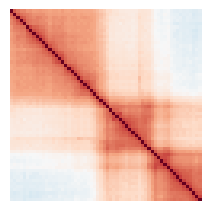

In [ ]:
m = sf.pp.median_pdist(adata[adata.obs["cell_type"] == "Ex"], False)
fig, ax = plt.subplots(figsize=(2, 2))
sf.pl.pairwise_heatmap(m, vmax=1000, cbar=False, ax=ax)

## Call loops and domains

```sh
mkdir 123ACElog/082925/brain25kb
scp "hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/082925/brain25kb/brain25kb_loop*" 123ACElog/082925/brain25kb/
scp "hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/082925/brain25kb/brain25kb_domain*" 123ACElog/082925/brain25kb/
```

In [9]:
cell1, cell2, chr_id = "Astro", "Pvalb", "chr14"
df1 = pd.read_csv(f"{out_dire}/brain25kb/brain25kb_loop_{cell1}.bedpe", sep="\t")
df2 = pd.read_csv(f"{out_dire}/brain25kb/brain25kb_loop_{cell2}.bedpe", sep="\t")

adata1 = fetch_adata(chr_id, cell1)
med_dist1 = sf.pp.median_pdist(adata1, False)
d1d = adata1.var.mean(axis=1).values
uidx = np.triu_indices(len(d1d), k=0)
x, y = list(map(lambda x: x[uidx], np.meshgrid(d1d, d1d)))
hm_df1 = pd.DataFrame({"x": x, "y": y, "dist": med_dist1[uidx]})

adata2 = fetch_adata(chr_id, cell2)
med_dist2 = sf.pp.median_pdist(adata2, False)
d1d = adata2.var.mean(axis=1).values
lidx = np.tril_indices(len(d1d), k=-1)
x2, y2 = list(map(lambda x: x[lidx], np.meshgrid(d1d, d1d)))
hm_df2 = pd.DataFrame({"x": x2, "y": y2, "dist": med_dist2[lidx]})

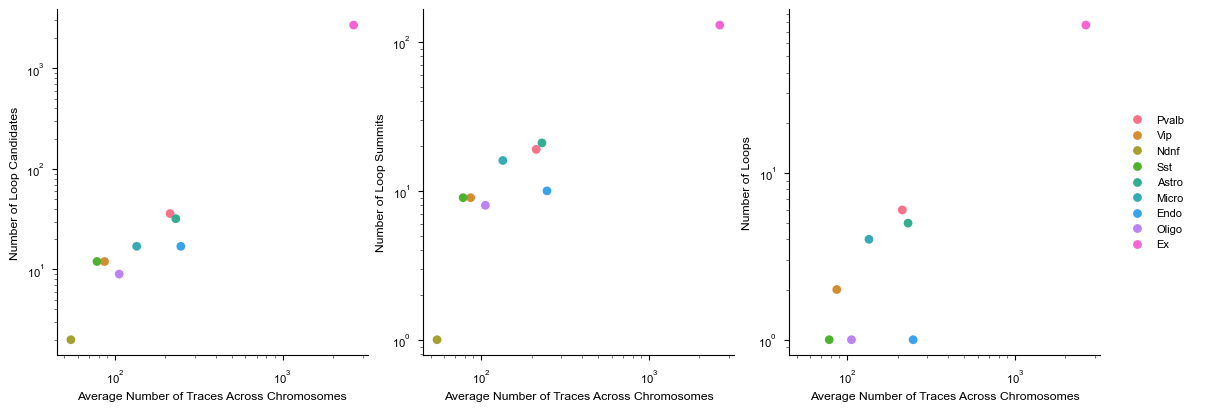

In [61]:
loop_by_celltype = []
for celltype in celltype_dict.values():
    df = pd.read_csv(f"{out_dire}/brain25kb/brain25kb_loop_{celltype}.bedpe", sep="\t")
    loop_by_celltype.append({
        "cell_type": celltype,
        "avg_traces": count_df[celltype].mean(),
        "candidate": len(df[df["candidate"]]),
        "summit": len(df[df["summit"]]),
        "loop": len(df[df["final"]])
    })
loop_by_celltype = pd.DataFrame(loop_by_celltype)
loop_by_celltype
fig, axes = plt.subplots(1, 4, figsize=(12, 4), width_ratios=[1, 1, 1, .3])
for ax, key in zip(axes[:3], ["candidate", "summit", "loop"]):
    sns.scatterplot(
        data=loop_by_celltype, x="avg_traces", y=key,
        hue="cell_type", s=40, linewidth=0, palette="husl", ax=ax
    )
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(False)
    ax.set_xlabel("Average Number of Traces Across Chromosomes")
    if key == "loop":
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().set_visible(False)
        ax.set_ylabel("Number of Loops")
    else:
        ax.get_legend().remove()
        ax.set_ylabel(f"Number of Loop {key.capitalize()}s")
axes[3].axis('off')
axes[3].legend(handles, labels, loc='center')
fig.savefig(f"{out_dire}/appl_loop_counts_by_celltype.pdf", bbox_inches='tight')

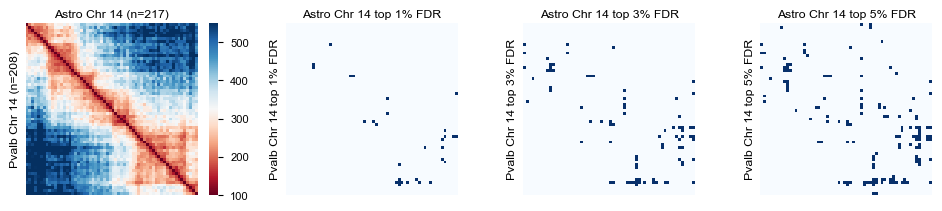

In [17]:
caller = sf.tl.LoopCaller()
fdr1 = caller.call_loops(adata1)["fdr"]
fdr2 = caller.call_loops(adata2)["fdr"]
fig, axes = plt.subplots(1, 4, figsize=(10, 2))
sf.pl.pairwise_heatmap(
    sf.pp.median_pdist(adata1, False), sf.pp.median_pdist(adata2, False),
    ax=axes[0], cbar=True, vmin=100, vmax=550,
    x=f"{cell1} Chr {chr_id[3:]} (n={adata1.n_obs})", 
    y=f"{cell2} Chr {chr_id[3:]} (n={adata2.n_obs})"
)
for pp, ax in zip([1, 3, 5], axes[1:]):
    pp1 = np.nanpercentile(fdr1[np.triu_indices_from(fdr1, k=1)], pp)
    pp2 = np.nanpercentile(fdr2[np.triu_indices_from(fdr2, k=1)], pp)
    sf.pl.pairwise_heatmap(
        fdr1 < pp1, fdr2 < pp2, ax=ax, cmap="Blues", cbar=False,
        x=f"{cell1} Chr {chr_id[3:]} top {pp}% FDR", 
        y=f"{cell2} Chr {chr_id[3:]} top {pp}% FDR"
    )
fig.savefig(f"{out_dire}/appl_loop_fdr.pdf", bbox_inches="tight")

In [ ]:
files = pd.Series(os.listdir(f"{out_dire}/brain25kb/"))
files = files[files.str.match(".*_loop_.*")]
files.index = files.str.replace(r"^.*_([^_]+).bedpe$", r"\g<1>", regex=True)
files = f"{out_dire}/brain25kb/" + files

X = {}
for cell_type, filepath in files.items():
    df = pd.read_csv(filepath, sep="\t")
    X[cell_type] = df["fdr"]
X = pd.DataFrame(X).dropna()
X = X.apply(lambda x: x < np.percentile(x, 10), axis=0)
# X = X.replace(False, np.nan).dropna(how="all").fillna(False)

In [ ]:
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro',
                 6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}
cell_types = list(celltype_dict.values())
loop_df = []
for cell_type in cell_types:
    df = pd.read_csv(
        f"{out_dire}/brain25kb/brain25kb_loop_{cell_type}.bedpe", 
        sep="\t"
    )
    df = df[df["summit"]].copy()
    df["cell_type"] = cell_type
    loop_df.append(df)
loop_df = pd.concat(loop_df, ignore_index=True)
loop_df.groupby("cell_type").size()

cell_type
Astro     21
Endo      10
Ex       130
Micro     16
Ndnf       1
Oligo      8
Pvalb     19
Sst        9
Vip        9
dtype: int64

In [ ]:
loop_df.groupby("c1").size()

c1
chr1     10
chr10    10
chr11    12
chr12     9
chr13     9
chr14    24
chr15     8
chr16    11
chr17    10
chr18     6
chr19    14
chr2     17
chr3     16
chr4      9
chr5      8
chr6     19
chr7      8
chr8      7
chr9      5
chrX     11
dtype: int64

In [ ]:
loop_df[loop_df["cell_type"] == "Micro"]

,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final,cell_type
59,chr1,136950000,136975000,chr1,137050000,137075000,9.256815e+03,3.438655e-05,0.048347,True,1.0,True,False,Micro
60,chr6,50300000,50325000,chr6,50525000,50550000,3.020194e+08,1.053938e-09,0.000001,True,1.0,True,True,Micro
61,chr13,21500000,21525000,chr13,21925000,21950000,2.080559e+03,1.529925e-04,0.078300,True,1.0,True,False,Micro
62,chr13,21850000,21875000,chr13,22025000,22050000,1.270396e+03,2.505595e-04,0.078300,True,2.0,True,False,Micro
63,chr4,89875000,89900000,chr4,90300000,90325000,6.924754e+03,4.596696e-05,0.054471,True,1.0,True,False,Micro
64,chr15,62075000,62100000,chr15,62275000,62300000,8.931624e+03,3.563852e-05,0.050001,True,1.0,True,False,Micro
65,chr19,12625000,12650000,chr19,12725000,12750000,1.601796e+03,1.987206e-04,0.058665,True,2.0,True,False,Micro
66,chr19,14275000,14300000,chr19,14800000,14825000,1.302216e+03,2.444370e-04,0.058665,True,3.0,True,False,Micro
67,chr19,14400000,14425000,chr19,14750000,14775000,4.478824e+05,7.106998e-07,0.000512,True,1.0,True,True,Micro
68,chrX,75375457,75400457,chrX,75850457,75875457,4.301505e+04,7.399965e-06,0.009405,True,1.0,True,True,Micro


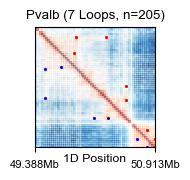

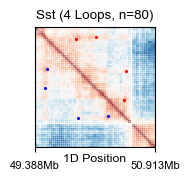

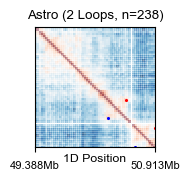

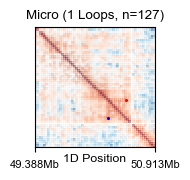

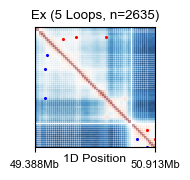

In [ ]:
for cell_type in cell_types:
    adata = fetch_adata("chr6", cell_type)
    plt_loops = loop_df[(loop_df["cell_type"] == cell_type)&(loop_df["c1"] == "chr6")]
    if plt_loops.empty:
        continue
    med_dist = sf.pp.median_pdist(adata, False)
    fig, ax = plt.subplots(figsize=(2, 2))
    d1d = adata.var.mean(axis=1).values
    x, y = list(map(lambda x: x.flatten(), np.meshgrid(d1d, d1d)))
    hm_df = pd.DataFrame({"x": x, "y": y, "dist": med_dist.flatten()})
    sns.scatterplot(hm_df, x="x", y="y", hue="dist", ax=ax,
                    palette="RdBu", s=6, marker="s", alpha=.4, linewidth=0)
    ax.set_title(f"{cell_type} ({len(plt_loops)} Loops, n={adata.n_obs})")
    ax.set(xlim=(d1d.min(), d1d.max()), ylim=(d1d.min(), d1d.max()))
    sf.pl.compare_loops(plt_loops, plt_loops, ax=ax)
    ax.get_legend().remove()

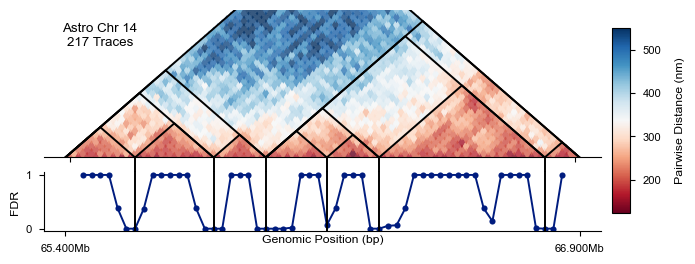

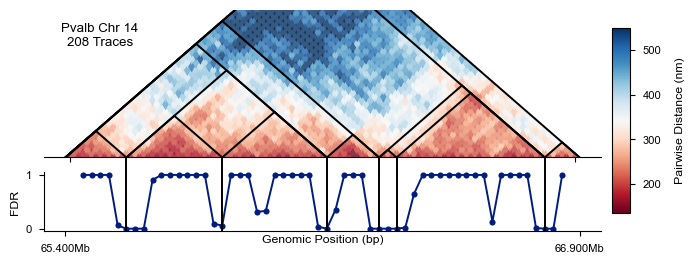

In [42]:
for c in ["Astro", "Pvalb"]:
    adata = fetch_adata("chr14", c)
    # Make sure the max is 550 and min is 100
    sf.pp.median_pdist(adata)
    adata.varp["med_dist"] = np.clip(
        adata.varp["med_dist"], a_min=100, a_max=550
    )
    
    caller2 = sf.tl.TADCaller(tree=True, method="pval", fdr_cutoff=.1)
    fig = plt.figure(figsize=(6.5, 2.3))
    ax, cbar, cax = sf.pl.triangle_domain_boundary(adata, caller2, s=35, fig=fig)
    ax.set_title(f"{c} Chr 14\n{adata.n_obs} Traces", y=0.7, x=0.1)
    cbar.set_label("Pairwise Distance (nm)", labelpad=10)
    fig.savefig(f"{out_dire}/appl_{c.lower()}_chr14.pdf", bbox_inches="tight")

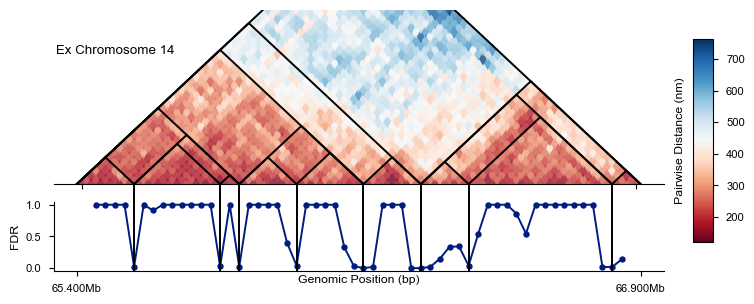

In [ ]:
adata = fetch_adata("chr14", "Ex")[:70,:].copy()
caller2 = sf.tl.TADCaller(tree=True, method="pval", fdr_cutoff=.1)
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata, caller2, fig=fig)
ax.set_title(f"Ex Chromosome 14", y=0.7, x=0.1)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)

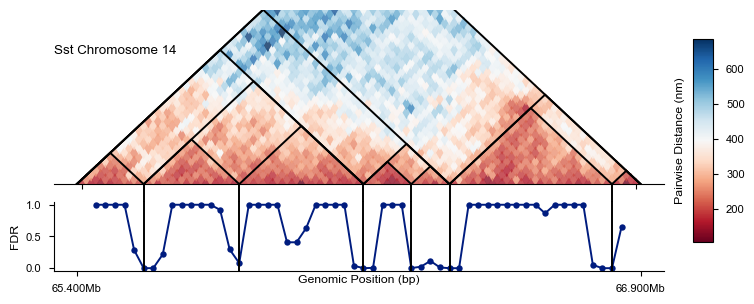

In [ ]:
adata = fetch_adata("chr14", "Sst")
caller2 = sf.tl.TADCaller(tree=True, method="pval", fdr_cutoff=.1)
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata, caller2, fig=fig)
ax.set_title(f"Sst Chromosome 14", y=0.7, x=0.1)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)

In [ ]:
fig.get_size_inches()/2

array([3.5, 2.5])

In [ ]:
mesc = sf.pp.FOF_CT_Loader({
    c: dtree["takei_nature_2021", "25Kb", c] for c in ["rep1", "rep2"]
}, voxel_ratio={"X": 1000, "Y": 1000, "Z": 1000})

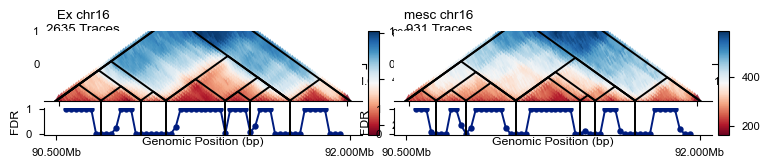

In [ ]:
caller2 = sf.tl.TADCaller(tree=True, method="pval", fdr_cutoff=.1)
# 4, 5, 8, 9
chr_id = "chr16"
# Chr 4: Zfp352 in Ex
# Chr 8: Triml1 in mESC
# Chr 9: Scn10a in mESC; D830035M03Rik in Ex


fig = plt.figure(figsize=(7, 2))
sfig = fig.subfigures(1, 2).flat
def get_size_inches():
    size = fig.get_size_inches()
    return (size[0], size[1])
for i, cell_type in enumerate(["Ex", "mesc"]):
    if cell_type == "mesc":
        adata = mesc.create_adata(chr_id)
    else:
        adata = fetch_adata(chr_id, cell_type)
    ax = fig.add_subplot(2, 2, i+1)
    sfig[i].get_size_inches = get_size_inches
    sf.pl.triangle_domain_boundary(adata, caller2, fig=sfig[i])
    ax.set_title(f"{cell_type} {chr_id}\n{adata.n_obs} Traces", y=0.7, x=0.1)

In [ ]:
df = pd.read_csv(f"{out_dire}/mesc_domain.csv")
df[df["peak"]].iloc[:,:3].to_csv(f"{out_dire}/igv_mesc.bed", sep="\t", index=False, header=False)

In [32]:
# scp "hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/082925/brain25kb/brain25kb_domain_rep.csv" 123ACElog/082925/brain25kb/
res = pd.read_csv(f"{out_dire}/brain25kb/brain25kb_domain_rep.csv")

In [ ]:
adata_glia = loader.create_adata("chr16")
sf.pp.add_cell_type(adata_glia, celldfs, "Cell_ID", "cluster label")
adata_glia.obs["cell_type"] = adata_glia.obs["cluster label"].map(celltype_dict)
adata_glia = adata_glia[adata_glia.obs["cell_type"].isin(["Micro", "Endo"])]
adata_glia

View of AnnData object with n_obs × n_vars = 352 × 60
    obs: 'Cell_ID', 'cluster label', 'cell_type'
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'

In [ ]:
glia_bed = caller2.call_tads(adata_glia)
glia_bed[glia_bed["peak"]].iloc[:,:3].to_csv(f"{out_dire}/igv_glia.bed", sep="\t", index=False, header=False)

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/eval.py:34: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = raw_var[i]


(<Axes: >,
 <Axes: xlabel='Genomic Position (bp)', ylabel='FDR'>)

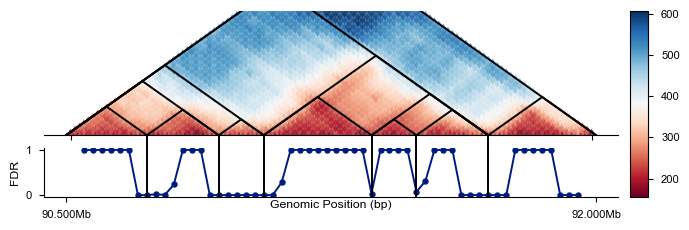

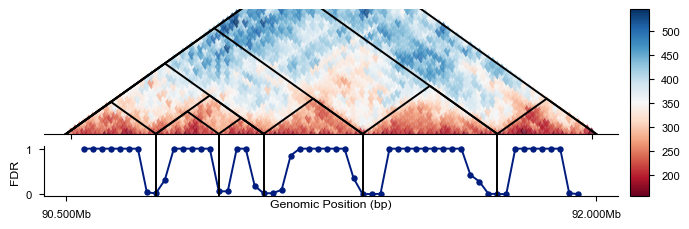

In [ ]:
fig = plt.figure(figsize=(7, 2.4))
adata = fetch_adata("chr16", "Ex")
sf.pl.triangle_domain_boundary(adata, caller2, fig=fig)

fig = plt.figure(figsize=(7, 2.4))
sf.pl.triangle_domain_boundary(adata_glia, caller2, fig=fig)

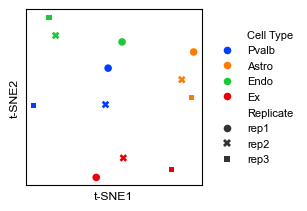

In [38]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

kept_cols = ["c1", "Chrom_Start", "Chrom_End", "fdr", "cell_type", "rep"]
res_sub = res[res["cell_type"].isin(["Astro", "Endo", "Pvalb", "Ex"])]
res_pivot = res_sub[kept_cols].pivot(
    index=["c1", "Chrom_Start", "Chrom_End"], 
    columns=["cell_type", "rep"], 
    values="fdr"
).sort_index().dropna()

tsne = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=1000)
tsne_df = pd.DataFrame(tsne.fit_transform(res_pivot.T),
            index=res_pivot.columns, columns=["t-SNE1", "t-SNE2"]).reset_index()
fig, ax = plt.subplots(figsize=(4.5, 2))
sns.scatterplot(tsne_df, x="t-SNE1", y="t-SNE2", hue="cell_type", style="rep",
                linewidth=0, s=30, palette="bright", ax=ax)
ax.set(xticks=[], yticks=[])
ax.spines[["top", "right"]].set_visible(True)
ax.set_box_aspect(1)
handles, labels = ax.get_legend_handles_labels()
labels[0] = "Cell Type"
labels[5] = "Replicate"
ax.legend(handles, labels, frameon=False, ncol=1, 
          bbox_to_anchor=(1.3, .5), loc="center")
ax.grid(True)
fig.savefig(f"{out_dire}/appl_tsne.pdf", bbox_inches="tight")

In [ ]:
domain_df = []
for cell_type in cell_types:
    df = pd.read_csv(
        f"{out_dire}/brain25kb/brain25kb_domain_{cell_type}.bedpe", 
        sep="\t"
    )
    df["cell_type"] = cell_type
    domain_df.append(df)
domain_df = pd.concat(domain_df, ignore_index=True)

## Excitatory neuron subset

In [8]:
mesc = sf.pp.FOF_CT_Loader({
    c: dtree["takei_nature_2021", "25Kb", c] for c in ["rep1", "rep2"]
}, voxel_ratio={"X": 1000, "Y": 1000, "Z": 1000})
mesc.create_adata("chr1").n_obs

937

In [88]:
ex_loop_path = f"{out_dire}/ex_loop.csv"
ex_domain_path = f"{out_dire}/ex_domain.csv"
mesc_domain_path = f"{out_dire}/mesc_domain.csv"
loop, domain = sf.tl.LoopCaller(), sf.tl.TADCaller()
if not os.path.exists(mesc_domain_path):
    loops, domains, mesc_tads = [], [], []
    for chr_id in [f"chr{t}" for t in range(1, 20)]:
        sub_adata = fetch_adata(chr_id, "Ex")[
            :mesc.create_adata(chr_id).n_obs].copy()
        sf.pp.filter_normalize(sub_adata)
        loops.append(
            loop.to_bedpe(loop.call_loops(sub_adata), sub_adata)
        )
        domains.append(domain.call_tads(sub_adata))
        
        sub_adata = mesc.create_adata(chr_id)
        sf.pp.filter_normalize(sub_adata)
        mesc_tads.append(domain.call_tads(sub_adata))
    loops = pd.concat(loops, ignore_index=True)
    loops.to_csv(ex_loop_path, index=False)
    domains = pd.concat(domains, ignore_index=True)
    domains.to_csv(ex_domain_path, index=False)
    mesc_tads = pd.concat(mesc_tads, ignore_index=True)
    mesc_tads.to_csv(mesc_domain_path, index=False)
else:
    loops = pd.read_csv(ex_loop_path)
    domains = pd.read_csv(ex_domain_path)
    mesc_tads = pd.read_csv(mesc_domain_path)

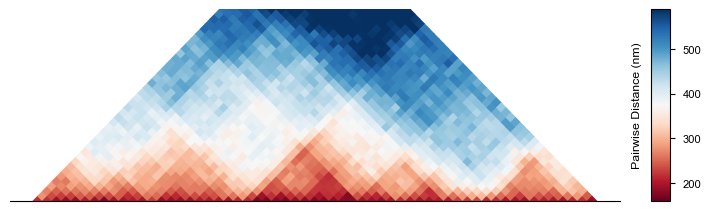

In [55]:
adata1_chr16 = mesc.create_adata("chr16")

mat = sf.pp.median_pdist(adata1_chr16, False)
mat = np.clip(mat, a_min=150, a_max=600)

from matplotlib.colors import Normalize
fig = plt.figure(figsize=(7, 2))
fig, ax, cbar = sf.pl.triangle_heatmap(
    mat, adata1_chr16.var, s=30, alpha=1, cut_hi=1e6, fig=fig, marker="D", 
    cmap="RdBu", hue_norm=Normalize(vmin=150, vmax=550)
)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.xaxis.set_visible(False)
fig.savefig(f"{out_dire}/appl_mesc_chr16_hm.pdf", bbox_inches="tight")

In [64]:
df = adata1_chr16.var.reset_index(drop=True)
df["chrom"] = adata1_chr16.uns["Chrom"]
df[["chrom", "Chrom_Start", "Chrom_End"]].to_csv(
    f"{out_dire}/appl_chr16_d1df.bed", sep="\t", index=False, header=False
)

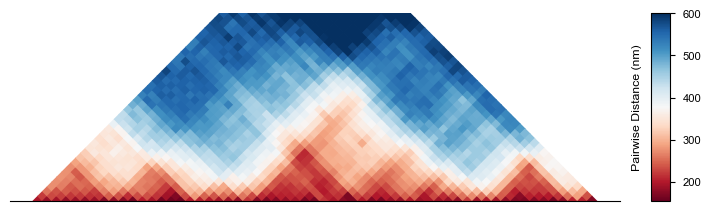

In [56]:
adata2_chr16 = fetch_adata("chr16", "Ex")

mat = sf.pp.median_pdist(adata2_chr16, False)
mat = mat.clip(min=150, max=600)

from matplotlib.colors import Normalize
fig = plt.figure(figsize=(7, 2))
fig, ax, cbar = sf.pl.triangle_heatmap(
    mat, adata2_chr16.var, s=30, alpha=1, cut_hi=1e6, fig=fig, marker="D", 
    cmap="RdBu", hue_norm=Normalize(vmin=150, vmax=550)
)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.xaxis.set_visible(False)
fig.savefig(f"{out_dire}/appl_ex_chr16_hm.pdf", bbox_inches="tight")

In [64]:
loops[loops["summit"]].iloc[:,:6].to_csv(f"{out_dire}/igv_ex_loops.bedpe", sep="\t", index=False, header=False)

In [65]:
domains[domains["peak"]].iloc[:,:3].to_csv(f"{out_dire}/igv_ex.bed", sep="\t", index=False, header=False)

In [ ]:
len(domains[domains["peak"]]), len(mesc_tads[mesc_tads["peak"]])

(115, 101)

In [66]:
from scipy.stats import fisher_exact
oddsratio, pvalue = fisher_exact([
    [len(domains[domains["peak"]]), len(mesc_tads[mesc_tads["peak"]])],
    [len(domains[~domains["peak"]]), len(mesc_tads[~mesc_tads["peak"]])]
])
pvalue

0.3525635146280462

In [67]:
c1, c2 = sns.palettes.color_palette("dark")[:2]
palette = {"Ex": c1, "mESC": c2}

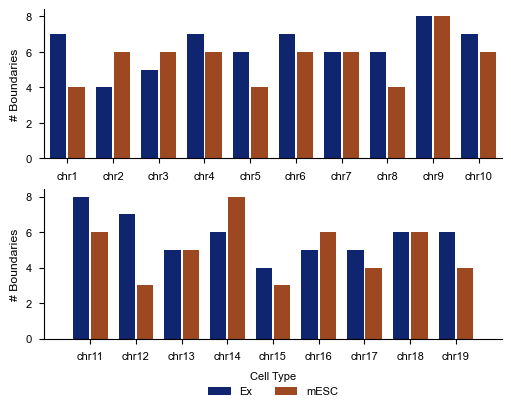

In [85]:
ex_count = (
    domains[domains["peak"]]
    .groupby("c1", sort=False).size()
    .reset_index(name="count")
)
ex_count["type"] = "Ex"
mesc_count = (
    mesc_tads[mesc_tads["peak"]]
    .groupby("c1", sort=False).size()
    .reset_index(name="count")
)
mesc_count["type"] = "mESC"

fig, axes = plt.subplots(2, 1, figsize=(5, 4))
sns.barplot(pd.concat([ex_count.loc[:9], mesc_count.loc[:9]]),
            x="c1", y="count", hue="type", gap=.1,
            palette=palette, ax=axes[0])
axes[0].get_legend().set_visible(False)
sns.barplot(pd.concat([ex_count.loc[10:], mesc_count.loc[10:]]),
            x="c1", y="count", hue="type", gap=.1,
            palette=palette, ax=axes[1])
axes[1].set_xlim(axes[1].get_xlim()[0] - .5, axes[1].get_xlim()[1] + .5)
axes[1].legend(loc="upper center", title="Cell Type", bbox_to_anchor=(0.5, -0.15), ncol=2)
for ax in axes:
    ax.grid(False)
    ax.set(xlabel="", ylabel="# Boundaries")
fig.savefig(f"{out_dire}/appl_ex_mesc_domain_counts.pdf", bbox_inches="tight")

In [69]:
domains_bed = (
    domains
    .set_index("c1")
    .groupby(level="c1", sort=False)
    .apply(lambda x: domain.to_bedpe(x.reset_index()))
    .reset_index(drop=True)
)
domains_bed["type"] = "Ex"
mesc_tad_bed = (
    mesc_tads
    .set_index("c1")
    .groupby(level="c1", sort=False)
    .apply(lambda x: domain.to_bedpe(x.reset_index()))
    .reset_index(drop=True)
)
mesc_tad_bed["type"] = "mESC"
bed_all = pd.concat([domains_bed, mesc_tad_bed], ignore_index=True)
bed_all["length"] = bed_all["e2"] - bed_all["s1"]

In [70]:
from scipy.stats import ttest_ind, mannwhitneyu
print("t-test:", round(ttest_ind(
    bed_all[bed_all["type"]=="Ex"].length.values,
    bed_all[bed_all["type"]=="mESC"].length.values
).pvalue, 3))
print("Mann-Whitney U:", round(mannwhitneyu(
    bed_all[bed_all["type"]=="Ex"].length.values,
    bed_all[bed_all["type"]=="mESC"].length.values
).pvalue, 3))

t-test: 0.37
Mann-Whitney U: 0.508


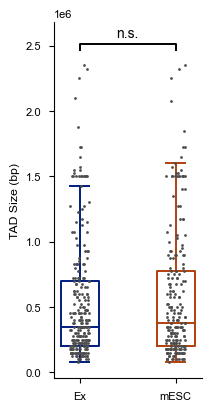

In [71]:
fig, ax = plt.subplots(figsize=(2, 4))
sns.boxplot(bed_all, x="type", y="length", hue="type", 
            fliersize=0, width=.4, fill=False, palette=palette, ax=ax)
sns.stripplot(bed_all, x="type", y="length", size=2, color=".3", ax=ax)
ax.set(ylabel="TAD Size (bp)", xlabel="")
m, h = ax.get_ylim()[1], np.ptp(ax.get_ylim())/50
ax.plot([1, 1, 0, 0], [m, m + h, m + h, m], color="k")
ax.annotate("n.s.", xy=(0, m), xytext=(.5, m+2*h), 
            ha="center", rotation=0)

ax.set(ylim=(ax.get_ylim()[0], ax.get_ylim()[1]+h))

ax.grid(False)

fig.savefig(f"{out_dire}/appl_tad_length.pdf", bbox_inches="tight")

In [72]:
tss = sf.tl.ABCaller(0, "mm10").tss
tss.columns = ["c1", "s1", "e1"]

In [73]:
tss_mesc = (sf.tl.signal_overlap(
    mesc_tads[mesc_tads["peak"]]
    .rename({"Chrom_Start":"s1", "Chrom_End":"e1"}, axis=1),
    tss, -1
).overlapped == 1).values
tss_exs = (sf.tl.signal_overlap(
    domains[domains["peak"]]
    .rename({"Chrom_Start":"s1", "Chrom_End":"e1"}, axis=1),
    tss, -1
).overlapped == 1).values

In [74]:
fisher_exact([
    [tss_exs.sum(), tss_mesc.sum()],
    [(~tss_exs).sum(), (~tss_mesc).sum()]
])

SignificanceResult(statistic=1.083984375, pvalue=0.7781202238820952)

In [75]:
mesc_peaks = mesc_tads[mesc_tads["peak"]].rename(
    {"Chrom_Start":"s1", "Chrom_End":"e1"}, axis=1
)
ex_peaks = domains[domains["peak"]].rename(
    {"Chrom_Start":"s1", "Chrom_End":"e1"}, axis=1
)
mesc_peaks["olap"] = sf.tl.signal_overlap(mesc_peaks, ex_peaks, -1).overlapped
ex_peaks["olap"] = sf.tl.signal_overlap(ex_peaks, mesc_peaks, -1).overlapped

mesc_peaks["tss"] = sf.tl.signal_overlap(mesc_peaks, tss, -1).overlapped
ex_peaks["tss"] = sf.tl.signal_overlap(ex_peaks, tss, -1).overlapped

In [76]:
mesc_tss_2by2 = mesc_peaks.groupby("olap")["tss"].agg(["sum", "size"])
mesc_tss_2by2["size"] -= mesc_tss_2by2["sum"]
print("mESC overlapped TSS:", fisher_exact(mesc_tss_2by2.values))

ex_tss_2by2 = ex_peaks.groupby("olap")["tss"].agg(["sum", "size"])
ex_tss_2by2["size"] -= ex_tss_2by2["sum"]
print("Ex overlapped TSS:", fisher_exact(ex_tss_2by2.values))

mESC overlapped TSS: SignificanceResult(statistic=0.9343434343434344, pvalue=1.0)
Ex overlapped TSS: SignificanceResult(statistic=1.0666666666666667, pvalue=1.0)


In [77]:
from scipy.stats import mannwhitneyu
print("mESC overlapped FDR:", mannwhitneyu(
    mesc_peaks[mesc_peaks["olap"]==1]["fdr"],
    mesc_peaks[mesc_peaks["olap"]==0]["fdr"], alternative="less"
))

print("Ex overlapped FDR:", mannwhitneyu(
    ex_peaks[ex_peaks["olap"]==1]["fdr"],
    ex_peaks[ex_peaks["olap"]==0]["fdr"], alternative="less"
))

mESC overlapped FDR: MannwhitneyuResult(statistic=845.5, pvalue=0.003308065050596053)
Ex overlapped FDR: MannwhitneyuResult(statistic=1205.0, pvalue=0.026157064271045638)


In [78]:
df1 = ex_peaks[["fdr", "olap"]].copy()
df1["cell_type"] = "Ex"
df2 = mesc_peaks[["fdr", "olap"]].copy()
df2["cell_type"] = "mESC"
fdr_df = pd.concat([df1, df2], ignore_index=True)
fdr_df["log10fdr"] = -np.log10(fdr_df["fdr"] + 1e-16)
fdr_df["olap"] = fdr_df["olap"].map({0:"No", 1:"Yes"})

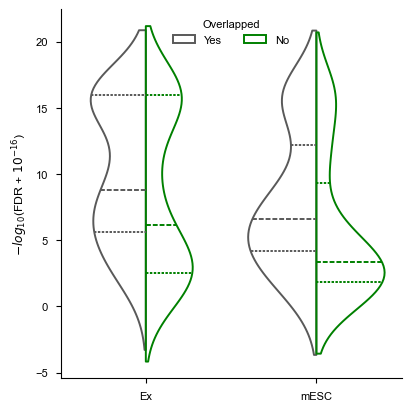

In [79]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.violinplot(data=fdr_df, x="cell_type", y="log10fdr", hue="olap",
               split=True, inner="quart", fill=False,
               palette={"No": "g", "Yes": ".35"}, ax=ax, orient="v")
ax.legend(title="Overlapped", loc="upper center", ncol=2)
ax.set(xlabel="", ylabel=r"$-log_{10}$(FDR + $10^{-16}$)")
ax.grid(False)
fig.savefig(f"{out_dire}/appl_tad_fdr.pdf", bbox_inches="tight")

In [80]:
marker_categories = {
    'Active Promoters': ['H3K4me3', 'H3K9ac', 'POLR2A'],
    'Enhancers': ['H3K4me1', 'H3K27ac'],
    'Gene Bodies': ['H3K36me3'],
    'Repressive': ['H3K9me3'],
    'Insulators': ['CTCF']
}

# Flatten the dictionary to create a mapping from marker to category
marker_to_category = {}
for category, markers in marker_categories.items():
    for marker in markers:
        marker_to_category[marker] = category

In [81]:
from utils.utils import domain_add_chipseq_col
for marker in dtree["chipseq_mesc"]:
    col = domain_add_chipseq_col(loops, marker, dtree)[marker]
    print(f"{marker}: {col.sum()}")

H3K4me3: 348
H3K4me1: 472
H3K27ac: 283
H3K36me3: 269
H3K9me3: 47
H3K9ac: 330
CTCF: 344
POLR2A: 135


In [82]:
from utils.utils import domain_add_chipseq_col
ors_chipseq = []
for marker in dtree["chipseq_mesc"]:
    mesc_peaks = domain_add_chipseq_col(mesc_peaks, marker, dtree)

    mesc_chipseq_2by2 = mesc_peaks.groupby("olap")[marker].agg(["sum", "size"])
    mesc_chipseq_2by2["size"] -= mesc_chipseq_2by2["sum"]
    val = mesc_chipseq_2by2.values
    
    orv, pval = fisher_exact(val, alternative="less")
    ors_chipseq.append({
        "marker": marker, "oddsratio": orv, "pvalue": pval, 
        "tot": mesc_peaks[marker].sum(),
        "category": marker_to_category.get(marker, "Other"),
        "ci_lower": np.exp(np.log(orv) - 1.96 * np.sqrt(1/val).sum()),
        "ci_upper": np.exp(np.log(orv) + 1.96 * np.sqrt(1/val).sum())
    })
ors_chipseq = pd.DataFrame(ors_chipseq)
ors_chipseq = ors_chipseq.sort_values(
    ["category", "oddsratio"], ascending=[True, False]
)
ors_chipseq

,marker,oddsratio,pvalue,tot,category,ci_lower,ci_upper
5,H3K9ac,0.792793,0.359648,40,Active Promoters,0.159718,3.935200
7,POLR2A,0.748299,0.375655,19,Active Promoters,0.112558,4.974773
0,H3K4me3,0.540541,0.096131,44,Active Promoters,0.109545,2.667262
2,H3K27ac,1.105263,0.671429,35,Enhancers,0.214421,5.697239
1,H3K4me1,0.590909,0.137076,50,Enhancers,0.120786,2.890838
3,H3K36me3,0.812693,0.384659,38,Gene Bodies,0.161956,4.078094
6,CTCF,0.551471,0.103426,49,Insulators,0.112437,2.704806
4,H3K9me3,1.071429,0.695467,5,Repressive,0.048784,23.531688


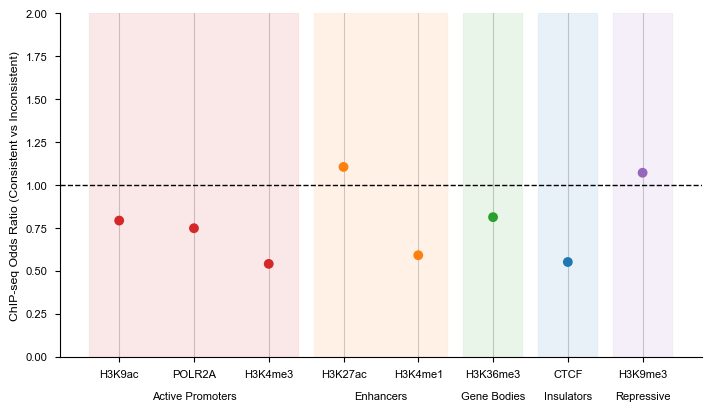

In [83]:
fig, ax = plt.subplots(figsize=(7, 4))

category_colors = {
    'Active Promoters': 'tab:red',
    'Enhancers': 'tab:orange',
    'Gene Bodies': 'tab:green',
    'Repressive': 'tab:purple',
    'Insulators': 'tab:blue',
    'Other': 'tab:gray'
}

sns.scatterplot(
    ors_chipseq, x="marker", y="oddsratio", hue="category",
    s=50, linewidth=0, ax=ax, legend="full", palette=category_colors
)
ax.axhline(1, color="k", linestyle="--", linewidth=1)

current_category = None
start_idx = 0
y_pos = np.arange(len(ors_chipseq))

for i, (_, row) in enumerate(ors_chipseq.iterrows()):
    if current_category != row["category"]:
        if current_category is not None:
            # Add background for the previous category
            ax.axvspan(start_idx-0.4, i-0.6, 
                      color=category_colors[current_category], alpha=0.1)
            # Add category label
            ax.text((start_idx + i - 1) / 2, -0.2, current_category,
                    ha='center', va='top', fontsize=8)
        
        current_category = row["category"]
        start_idx = i

ax.axvspan(start_idx-0.4, len(ors_chipseq)-0.6, 
          color=category_colors[current_category], alpha=0.1)
ax.text((start_idx + len(ors_chipseq) - 1) / 2, -0.2, current_category,
       ha='center', va='top', fontsize=8)

ax.set(ylim=(0, 2), xlabel="", ylabel="ChIP-seq Odds Ratio (Consistent vs Inconsistent)")
ax.get_legend().set_visible(False)

ax.set_axisbelow(True)
ax.grid(axis="y")

fig.savefig(f"{out_dire}/appl_mesc_chipseq_enrichment.pdf", bbox_inches="tight")

### Loops

In [ ]:
mesc.create_adata(chr_id).var.loc[["loc17"]]

,Chrom_Start,Chrom_End
locus,,
loc17,13175000,13200000


In [ ]:
sf.tl.overlap(tss[tss["c1"]=="chr16"].values[:,1:], np.array([[90925000, 90950000]]), -1).sum()

NameError: name 'tss' is not defined

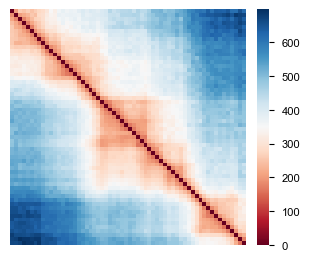

In [ ]:
chr_id = "chr16"
caller = sf.tl.TADCaller()
# fig, axes = plt.subplots(1, 2, figsize=(7, 3))
# sf.pl.domain_boundary(mesc.create_adata(chr_id), caller, ax=axes[0])
# sf.pl.domain_boundary(fetch_adata(chr_id, "Ex"), caller, ax=axes[1])
fig, ax = plt.subplots(figsize=(3, 2.5))
sf.pl.pairwise_heatmap(
    sf.pp.median_pdist(mesc.create_adata(chr_id), False), 
    sf.pp.median_pdist(fetch_adata(chr_id, "Ex"), False), ax=ax
)

In [ ]:
res_sf2_path = os.path.join(out_dire, "loop_result_sf2.csv")
res_sf2 = pd.read_csv(res_sf2_path, sep="\t")
res_sf2[res_sf2["final"]].shape[0], loops[loops["final"]].shape[0]

(25, 47)

In [ ]:
fisher_exact([
    [res_sf2[res_sf2["final"]].shape[0], loops[loops["final"]].shape[0]],
    [res_sf2[~res_sf2["final"]].shape[0], loops[~loops["final"]].shape[0]]
])

SignificanceResult(statistic=0.5049695511615668, pvalue=0.0062790849447662365)

<Axes: xlabel='type', ylabel='logfdr'>

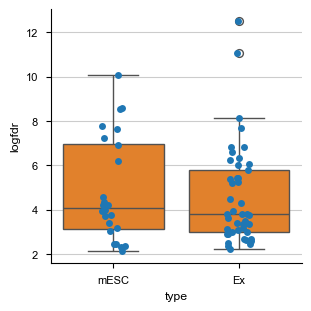

In [ ]:
l1 = res_sf2[res_sf2["final"]].copy()
l2 = loops[loops["final"]].copy()
l1["type"] = "mESC"
l2["type"] = "Ex"
l1 = pd.merge(l1, sf.tl.loop_overlap(l1, l2), 
              on=["c1", "s1", "e1", "c2", "s2", "e2"])
l2 = pd.merge(l2, sf.tl.loop_overlap(l2, l1), 
              on=["c1", "s1", "e1", "c2", "s2", "e2"])
final_df = pd.concat([l1, l2], ignore_index=True)
final_df["logfdr"] = -np.log10(final_df["fdr"])
fig, ax = plt.subplots(figsize=(3, 3))
sns.stripplot(data=final_df, x="type", y="logfdr", ax=ax)
sns.boxplot(data=final_df, x="type", y="logfdr", ax=ax)

In [ ]:
from scipy.stats import mannwhitneyu
mannwhitneyu(l1.fdr, l2.fdr)

MannwhitneyuResult(statistic=542.0, pvalue=0.5945320119657429)

<Axes: xlabel='o', ylabel='logfdr'>

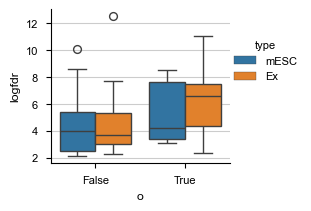

In [ ]:
final_df["o"] = final_df["overlapped"]==3
fig, ax = plt.subplots(figsize=(3, 2))
sns.boxplot(final_df, x="o", y="logfdr", hue="type", ax=ax)

In [ ]:
l1[l1.overlapped!=3].sort_values("fdr").head()

,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final,type,overlapped
16,chr13,22050000,22075000,chr13,22275000,22300000,5.360204e+15,0.000000e+00,0.000000e+00,True,1.0,True,True,mESC,0
17,chr13,23275000,23300000,chr13,23400000,23425000,4.647177e+11,6.850076e-13,8.562595e-11,True,10.0,True,True,mESC,0
15,chr13,21900000,21925000,chr13,22000000,22025000,1.122650e+10,2.835343e-11,2.531556e-09,True,3.0,True,True,mESC,1
24,chr16,91200000,91225000,chr16,91350000,91375000,1.809852e+09,1.758762e-10,1.236410e-07,True,3.0,True,True,mESC,1
18,chr13,23300000,23325000,chr13,23500000,23525000,2.739386e+07,1.161975e-08,6.051954e-07,True,12.0,True,True,mESC,1


In [ ]:
l2[l2.overlapped!=3].sort_values("fdr").head()

,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final,type,overlapped
41,chr14,66175000,66200000,chr14,66275000,66300000,6.063976e+14,4.440892e-16,3.121947e-13,True,5.0,True,True,Ex,0
6,chr4,90550000,90575000,chr4,90700000,90725000,1.815121e+10,1.753653e-11,2.078079e-08,True,2.0,True,True,Ex,0
22,chr8,44000000,44025000,chr8,44125000,44150000,2.543239e+09,1.251592e-10,1.521936e-07,True,3.0,True,True,Ex,0
10,chr6,49525000,49550000,chr6,50275000,50300000,2.262511e+08,1.406887e-09,4.783417e-07,True,8.0,True,True,Ex,0
38,chr14,65425000,65450000,chr14,65575000,65600000,1.584932e+08,2.008350e-09,5.647482e-07,True,3.0,True,True,Ex,0


In [ ]:
a, b = res_sf2[res_sf2["final"]], loops[loops["final"]]
olap_df = {}
for err in [-1, 0, 25e3]:
    o1 = sf.tl.loop_overlap(a, b, err).overlapped==3
    o2 = sf.tl.loop_overlap(b, a, err).overlapped==3
    olap_df[err] = ((~o1).sum(), (~o2).sum(), o1.sum(), o2.sum())
olap_df = pd.DataFrame(olap_df, index=["mESC only", "Ex only", "Both1", "Both2"]).T
olap_df.index = ["Exact", "±25Kb", "±50kb"]
print(olap_df)
olap_df = olap_df.drop("Both1", axis=1)
olap_df.columns = ["mESC only", "Ex only", "Overlapped"]
olap_df = olap_df/olap_df.sum(axis=1).values[:,None]

       mESC only  Ex only  Both1  Both2
Exact         20       42      5      5
±25Kb         16       38      9      9
±50kb         15       37     10     10


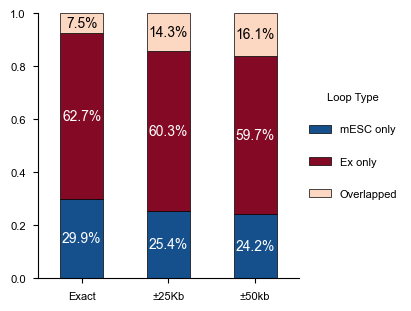

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
olap_df.plot(kind="bar", stacked=True, ax=ax, width=.5, color={
    "mESC only": plt.colormaps["RdBu"](240),
    "Ex only": plt.colormaps["RdBu"](10),
    "Overlapped": plt.colormaps["RdBu"](100)
}, linewidth=.5, edgecolor="k",)
ax.legend(title="Loop Type", bbox_to_anchor=(1, .5), 
          loc="center left", labelspacing=2)
ax.set(ylim=(0, 1))

for i, (idx, row) in enumerate(olap_df.iterrows()):
    cumsum = 0
    for j, (col, val) in enumerate(row.items()):
        if val > 0.05:  # Only label if percentage > 5%
            ax.text(i, cumsum + val/2, f'{val:.1%}', 
                   ha='center', va='center',  
                   color='white' if j != 2 else 'black')  # white text except for middle color
        cumsum += val

ax.tick_params(axis='x', rotation=0)
ax.grid(False)
fig.savefig(f"{out_dire}/appl_loop_overlap.pdf", bbox_inches="tight")

In [ ]:
chr_id = "chr6"
adata1 = mesc.create_adata(chr_id)
med_dist1 = sf.pp.median_pdist(adata1, False)
d1d = adata1.var.mean(axis=1).values
uidx = np.triu_indices(len(d1d), k=0)
x, y = list(map(lambda x: x[uidx], np.meshgrid(d1d, d1d)))
hm_df1 = pd.DataFrame({"x": x, "y": y, "dist": med_dist1[uidx]})

adata2 = fetch_adata(chr_id, "Ex")
med_dist2 = sf.pp.median_pdist(adata2, False)
d1d = adata2.var.mean(axis=1).values
lidx = np.tril_indices(len(d1d), k=-1)
x2, y2 = list(map(lambda x: x[lidx], np.meshgrid(d1d, d1d)))
hm_df2 = pd.DataFrame({"x": x2, "y": y2, "dist": med_dist2[lidx]})

hm_df = pd.concat([hm_df1, hm_df2])

diff_med_dist = med_dist1 - med_dist2
diff_df = pd.concat([
    pd.DataFrame({"x": x, "y": y, "dist": diff_med_dist[uidx]}),
    pd.DataFrame({"x": x2, "y": y2, "dist": diff_med_dist[lidx]})
])

In [ ]:
l1[l1["c1"]==chr_id]

,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final,type,overlapped
9,chr6,50300000,50325000,chr6,50525000,50550000,7.145024e+09,4.454981e-11,6.058774e-08,True,1.0,True,True,mESC,3
10,chr6,50675000,50700000,chr6,50800000,50825000,1.741511e+06,1.827780e-07,6.214450e-05,True,8.0,True,True,mESC,3


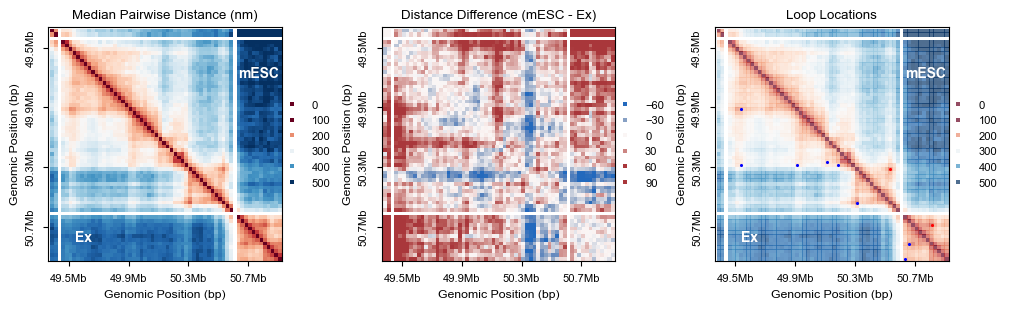

In [ ]:
from matplotlib.colors import Normalize
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
norm = Normalize(vmin=100, vmax=475)
sns.scatterplot(hm_df, x="x", y="y", hue="dist", ax=axes[0], hue_norm=norm,
                palette="RdBu", s=9, marker="s", alpha=1, linewidth=0)
axes[0].set(title="Median Pairwise Distance (nm)")

axes[0].annotate("Ex", xy=(0.15, 0.1), xycoords="axes fraction",
                 fontsize=10, ha="center", va="center", fontweight="bold", color="w")
axes[0].annotate("mESC", xy=(0.9, 0.8), xycoords="axes fraction",
                 fontsize=10, ha="center", va="center", fontweight="bold", color="w")

norm = Normalize(vmin=-50, vmax=50)
sns.scatterplot(diff_df, x="x", y="y", hue="dist", ax=axes[1], hue_norm=norm,
                palette="vlag", s=9, marker="s", alpha=1, linewidth=0)
axes[1].set(title="Distance Difference (mESC - Ex)")

norm = Normalize(vmin=100, vmax=475)
sns.scatterplot(hm_df, x="x", y="y", hue="dist", ax=axes[2], hue_norm=norm,
                palette="RdBu", s=9, marker="s", alpha=.7, linewidth=0)
sf.pl.compare_loops(l1[l1["c1"]==chr_id], l2[l2["c1"]==chr_id], ax=axes[2])
axes[2].set(title="Loop Locations")

axes[2].annotate("Ex", xy=(0.15, 0.1), xycoords="axes fraction",
                 fontsize=10, ha="center", va="center", fontweight="bold", color="w")
axes[2].annotate("mESC", xy=(0.9, 0.8), xycoords="axes fraction",
                 fontsize=10, ha="center", va="center", fontweight="bold", color="w")

for ax in axes:
    ax.grid(False)
    ax.yaxis.set_inverted(True)
    ax.set_box_aspect(1)
    lim = (d1d.min() - 25e3, d1d.max() + 15e3)
    ax.set(xlim=lim, ylim=(lim[1], lim[0]), 
           xlabel="Genomic Position (bp)", ylabel="Genomic Position (bp)")
    ax.xaxis.set_label_coords(0.5, -.12)
    ax.spines[["top", "right"]].set_visible(True)
    ticks = np.arange(np.ceil(lim[0]/25e4)*25e4, np.ceil(lim[1]/25e4)*25e4, 4e5)
    xlabels = [f"{tick/1e6:.1f}Mb" for tick in ticks]
    ax.set(xticks=ticks, xticklabels=xlabels, yticks=ticks)
    ax.set_yticklabels(xlabels, rotation=90, va="center")
    
    ax.legend(title=None, loc="right", bbox_to_anchor=(1.25, 0.5))

fig.savefig(f"{out_dire}/appl_mesc_ex_loop.pdf", bbox_inches="tight")

In [ ]:
df = pd.read_csv(f"{out_dire}/loop_result_sf2.csv", sep="\t")
df[df["final"]].iloc[:,:6].to_csv(f"{out_dire}/igv_mesc_loops.bedpe", sep="\t", index=False, header=False)

In [ ]:
l1[l1["c1"]==chr_id].iloc[:,:6].to_csv(
    f"{out_dire}/appl_mesc_loops_chr6.bedpe",
    index=False, header=False, sep="\t"
)

In [ ]:
l2[l2["c1"]==chr_id].iloc[:,:6].to_csv(
    f"{out_dire}/appl_ex_loops_chr6.bedpe", 
    index=False, header=False, sep="\t"
)

## Differential TAD demo

In [ ]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)
sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro',
                 6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}
adata.obs["cell_type"] = adata.obs["cluster label"].map(celltype_dict)

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:19: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]
/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:19: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]


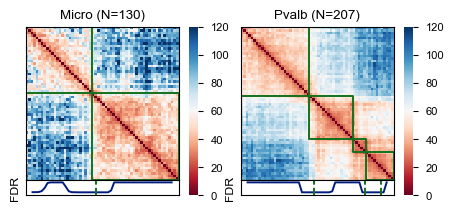

In [ ]:
adata1 = adata[adata.obs["cell_type"] == "Micro"]
adata2 = adata[adata.obs["cell_type"] == "Pvalb"]
caller = sf.tl.TADCaller(tree=False, window=4e5)
fig, axes = plt.subplots(1, 2, figsize=(4.3, 2))
sf.pl.domain_boundary(adata1, caller, ax=axes[0], vmax=120, 
                      title=f"Micro (N={adata1.shape[0]})")
sf.pl.domain_boundary(adata2, caller, ax=axes[1], vmax=120, 
                      title=f"Pvalb (N={adata2.shape[0]})")
fig.savefig(os.path.join(out_dire, "Micro_Pvalb_TADs.pdf"), bbox_inches="tight")

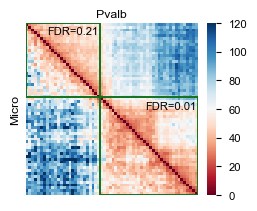

In [ ]:
caller = sf.tl.TADCaller(tree=False, window=4e5)
res = caller.to_bedpe(caller.call_tads(adata1))
diff = sf.tl.DiffRegion(adata1, adata2)
res_diff = diff.diff_region(res)

fig, ax = plt.subplots(figsize=(2.5, 2))
sf.pl.pairwise_heatmap(
    X2=sf.pp.median_pdist(adata1, inplace=False),
    X1=sf.pp.median_pdist(adata2, inplace=False),
    y="Micro", x="Pvalb", ax=ax, vmax=120
)
sf.pl.add_domain_fdr(ax, res_diff)
fig.savefig(os.path.join(out_dire, "Micro_Pvalb_dTAD.pdf"), bbox_inches="tight")

In [ ]:
res_diff

,c1,s1,e1,c2,s2,e2,stat1,stat2,level,idx1,idx2,stat,pval,fdr,log_fdr
0,chr3,7675000,7700000,chr3,8525000,8550000,NaN,1.633124e+16,0,0,28,4.183317,0.074689,0.074689,-2.594426
1,chr3,8525000,8550000,chr3,9300000,9325000,1.633124e+16,NaN,0,28,59,16.300974,0.019503,0.039005,-3.244060


/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:22: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]


/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:22: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]


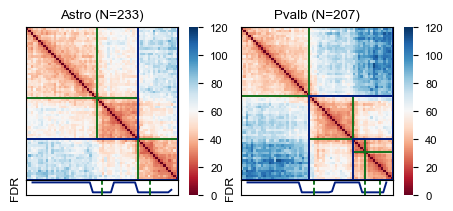

In [ ]:
adata1 = adata[adata.obs["cell_type"] == "Astro"]
adata2 = adata[adata.obs["cell_type"] == "Pvalb"]
caller = sf.tl.TADCaller(tree=True, window=4e5)
fig, axes = plt.subplots(1, 2, figsize=(4.3, 2))
sf.pl.domain_boundary(adata1, caller, ax=axes[0], vmax=120, 
                      title=f"Astro (N={adata1.shape[0]})")
sf.pl.domain_boundary(adata2, caller, ax=axes[1], vmax=120, 
                      title=f"Pvalb (N={adata2.shape[0]})")
fig.savefig(os.path.join(out_dire, "Astro_Pvalb_TADs.pdf"), bbox_inches="tight")

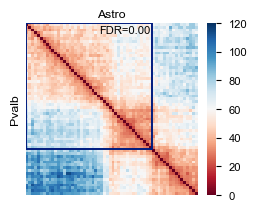

In [ ]:
caller = sf.tl.TADCaller(tree=True, window=4e5)
res = caller.to_bedpe(caller.call_tads(adata1))
diff = sf.tl.DiffRegion(adata1, adata2)
res_diff = diff.diff_region(res[res["level"]==1])

fig, ax = plt.subplots(figsize=(2.5, 2))
sf.pl.pairwise_heatmap(
    X1=sf.pp.median_pdist(adata1, inplace=False),
    X2=sf.pp.median_pdist(adata2, inplace=False),
    x="Astro", y="Pvalb", ax=ax, vmax=120
)
sf.pl.add_domain_fdr(ax, res_diff)
fig.savefig(os.path.join(out_dire, "Astro_Pvalb_dTAD.pdf"), bbox_inches="tight")

## Control type I error rate

In [ ]:
loaders = {
    c: sf.pp.FOF_CT_Loader(dtree["takei_science_2021", "25Kb", c], 
                           voxel_ratio={"X": 103, "Y": 103, "Z": 250}, 
                           obs_cols_add=["Cell_ID"])
    for c in ["rep1", "rep2", "rep3"]
}
for k, v in loaders.items():
    adata = v.create_adata("chr3")
    sf.pp.add_cell_type(adata, celldfs[k], "Cell_ID", "cluster label")

In [ ]:
dtree["takei_nature_2021", "25Kb", "rep2"]

'../data/takei_nature_2021/4DNFIQXONUUH.csv'

In [ ]:
chr_id = "chr3"
rep1 = loaders["rep1"].create_adata(chr_id)
rep2 = loaders["rep2"].create_adata(chr_id)
diff = sf.tl.DiffRegion(rep1, rep2)
diff.diff_region()

AnnData object with n_obs × n_vars = 1615 × 60
    obs: 'Cell_ID', 'cluster label'
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'

## Differential loop demo

In [ ]:
oadata = adata[adata.obs["cell_type"] == "Ex"]
sf.pp.filter_normalize(oadata)
loop = sf.tl.LoopCaller()
loop_res = loop.call_loops(oadata)
loop_df = loop.to_bedpe(loop_res, oadata)

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/eval.py:34: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = raw_var[i]


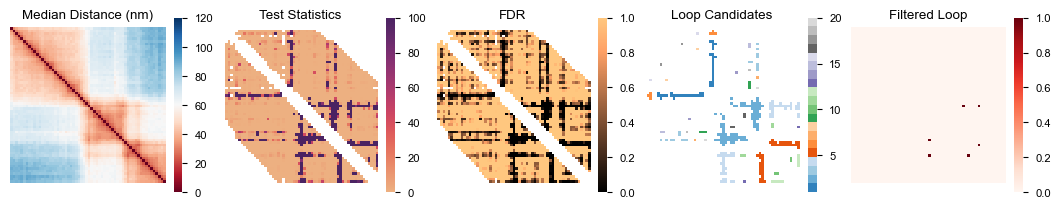

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(10.5, 2))
sf.pl.pairwise_heatmap(sf.pp.median_pdist(oadata, inplace=False), ax=axes[0], vmax=120, title="Median Distance (nm)")
sf.pl.pairwise_heatmap(loop_res["stat"], ax=axes[1], cmap="flare", vmin=0, vmax=1e2, title="Test Statistics")
sf.pl.pairwise_heatmap(loop_res["fdr"], ax=axes[2], cmap="copper", vmax=1, title="FDR")
sf.pl.pairwise_heatmap(loop_res["label"], ax=axes[3], cmap="tab20c", title="Loop Candidates")
sf.pl.pairwise_heatmap(loop_res["final"], ax=axes[4], cmap="Reds", title="Filtered Loop")
fig.savefig(os.path.join(out_dire, "Ex_Loop.pdf"), bbox_inches="tight")

In [ ]:
adata_endo = adata[adata.obs["cell_type"] == "Endo"]
adata_astro = adata[adata.obs["cell_type"] == "Astro"]

Found 0 differential loops, while 6 are not differential loops.


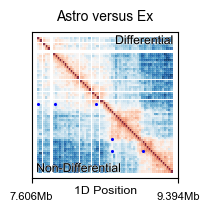

In [ ]:
from utils.maps import pair_loop_map
diffloop = sf.tl.DiffLoop(adata_astro, oadata)
res = diffloop.diff_loops(loop_df[loop_df["final"]])
df = diffloop.to_bedpe(res, 0.1)
fig = pair_loop_map(adata_astro, oadata, df, "chr3")
fig.suptitle("Astro versus Ex", fontsize=10)
fig.savefig(os.path.join(out_dire, "Astro_Ex_Loop.pdf"), bbox_inches="tight")

In [ ]:
df[["c1", "s1", "e1", "c2", "s2", "e2", "fdr"]]

,c1,s1,e1,c2,s2,e2,fdr
0,chr3,7675000,7700000,chr3,8475000,8500000,0.915455
1,chr3,7875000,7900000,chr3,8475000,8500000,0.915455
2,chr3,8375000,8400000,chr3,8475000,8500000,0.915455
3,chr3,8575000,8600000,chr3,8900000,8925000,0.915455
4,chr3,8575000,8600000,chr3,9050000,9075000,0.915455
5,chr3,8950000,8975000,chr3,9050000,9075000,0.243232


Found 4 differential loops, while 2 are not differential loops.


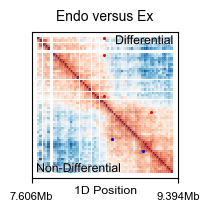

In [ ]:
diffloop = sf.tl.DiffLoop(adata_endo, oadata)
res = diffloop.diff_loops(loop_df[loop_df["final"]])
df = diffloop.to_bedpe(res, 0.1)
fig = pair_loop_map(adata_endo, oadata, df, "chr3")
fig.suptitle("Endo versus Ex", fontsize=10)
fig.savefig(os.path.join(out_dire, "Endo_Ex_Loop.pdf"), bbox_inches="tight")

In [ ]:
df[["c1", "s1", "e1", "c2", "s2", "e2", "fdr"]]

,c1,s1,e1,c2,s2,e2,fdr
0,chr3,7675000,7700000,chr3,8475000,8500000,0.041236
1,chr3,7875000,7900000,chr3,8475000,8500000,0.000067
2,chr3,8375000,8400000,chr3,8475000,8500000,0.014833
3,chr3,8575000,8600000,chr3,8900000,8925000,0.416674
4,chr3,8575000,8600000,chr3,9050000,9075000,0.037286
5,chr3,8950000,8975000,chr3,9050000,9075000,0.416674


Found 0 differential loops, while 6 are not differential loops.


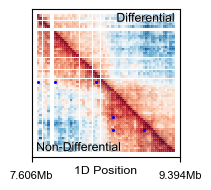

In [ ]:
diffloop = sf.tl.DiffLoop(adata_astro, oadata)
res = diffloop.diff_loops(loop_df[loop_df["final"]])
df = diffloop.to_bedpe(res, 0.1)
fig = pair_loop_map(adata_endo, oadata, df, "chr3")
fig.savefig(os.path.join(out_dire, "Endo_Astro_Loop.pdf"), bbox_inches="tight")

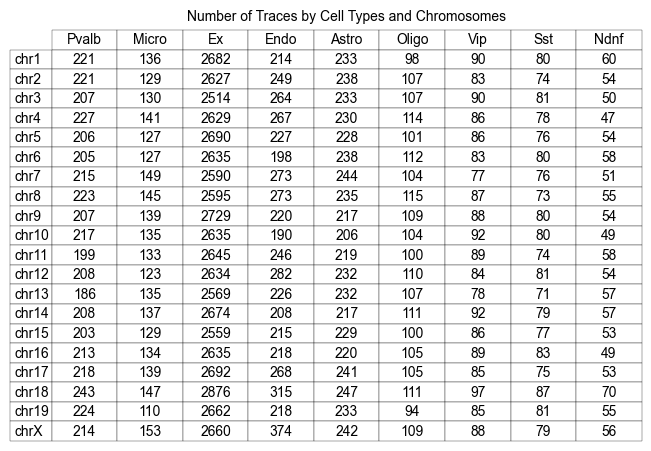

In [ ]:
rows = []
for chr_id in loader.chr_ids:
    adata = loader.create_adata(chr_id)
    sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
    adata.obs["cell_type"] = adata.obs["cluster label"].map(celltype_dict)
    d = Counter(adata.obs["cell_type"])
    d["Chrom"] = chr_id
    rows.append(d)
df = pd.DataFrame(rows).sort_values("Chrom").set_index("Chrom")
df = df.loc[[f"chr{i}" for i in range(1, 20)]+["chrX"]]
fig, ax = plt.subplots()
ax.axis("off")
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, 
         cellLoc="center", loc="center")
ax.set_title("Number of Traces by Cell Types and Chromosomes", 
             y=1.02, fontsize=10)
out_fname = os.path.join(out_dire, "takei_science_count.pdf")
fig.savefig(out_fname, bbox_inches="tight")

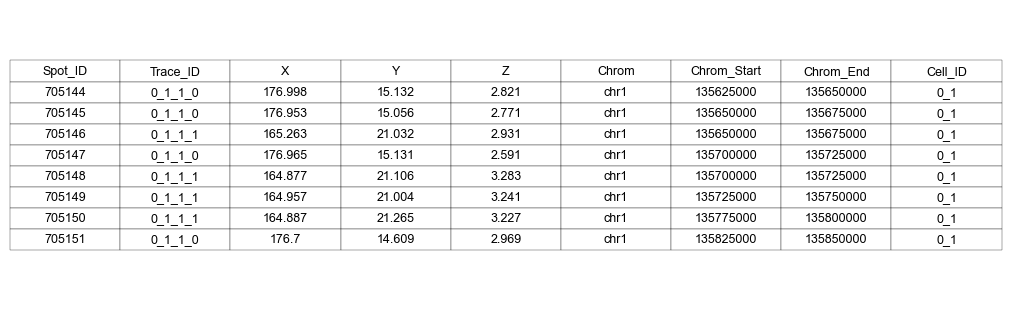

In [ ]:
df = pd.read_csv(dtree["takei_nature_2021","25Kb","rep1"], skiprows=14)
cols = df.columns.values; cols[0] = "Spot_ID"; cols[-1] = "Extra_Cell_ROI_ID"
df.columns = cols; df = df.iloc[:8,:-1]
fig, ax = plt.subplots(figsize=(10, 3))
ax.table(cellText=df.values, colLabels=df.columns, loc="center", cellLoc="center")
ax.axis("off")
fig.savefig(os.path.join(out_dire, "fof_ct.pdf"), bbox_inches="tight")

## 129 and CAST allele

In [ ]:
dtree["huang_ng_2021"]

{'between': '4DNFI2RCYFJU.csv',
 'between_rna': '4DNFI9KE6AII.csv',
 'downstream': '4DNFI5Y2PIJM.csv',
 'downstream_rna': '4DNFIKPGMZJ8.csv',
 'between_mutant': '4DNFIA8DHAFV.csv'}

`between` and `between_rna` are the experimental groups. 4 CTCF binding sites are inserted between the Sox2 promoter and the super enhancer in the CAST allele. This should lower the Sox2 expression from CAST allele. `between_rna` also has Sox2 RNA expression level.

`downstream` and `downstream_rna` are the control groups. The CTCF binding sites are inserted downstream of the system instead of between the enhancer and the promoter. We expect no significant difference.

In [ ]:
loader_ng = sf.pp.FOF_CT_Loader(dtree["huang_ng_2021","between_mutant"])
adatab = loader_ng.create_adata("chr3")
allele = adatab.obs.index.str.replace(r"^\d+_", "", regex=True)
adatab.obs["allele"] = allele
adatab129 = adatab[adatab.obs["allele"] == "129"]
adatabcast = adatab[adatab.obs["allele"] == "CAST"]
sf.pp.axis_weight(adatab, inplace=False)

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(


array([0.35155619, 0.36190932, 0.28653449])

In [ ]:
adatab

AnnData object with n_obs × n_vars = 1318 × 41
    obs: 'allele'
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'

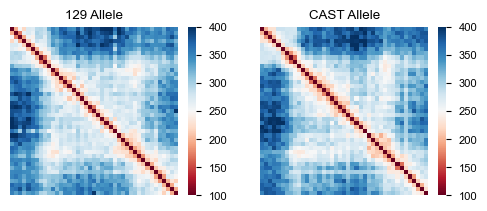

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2))
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adatab129, inplace=False), ax=axes[0],
                       title="129 Allele", vmin=100, vmax=400)
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adatabcast, inplace=False), ax=axes[1],
                       title="CAST Allele", vmin=100, vmax=400)

In [ ]:
caller = sf.tl.LoopCaller()
loop_res = caller.call_loops(adatab)
loop_df = caller.to_bedpe(loop_res, adatab)
loop_df[loop_df["final"]]

,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final
344,chr3,34646078,34651078,chr3,34751078,34756078,7.096426e+11,4.485301e-13,1.036105e-10,True,1.0,True,True


In [ ]:
row = loop_df[loop_df["final"]].iloc[0]
adatab.var[adatab.var["Chrom_Start"].isin([row.s1, row.s2])]

,Chrom_Start,Chrom_End
locus,,
loc9,34646078,34651078
loc30,34751078,34756078


In [ ]:
df = caller.to_bedpe(caller.call_loops(adatab129), adatab129)
df[df["summit"]]

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:187: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["weight"] = {


,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final
344,chr3,34646078,34651078,chr3,34751078,34756078,7.063764e+11,4.505285e-13,1.040721e-10,True,1.0,True,True


In [ ]:
df = caller.to_bedpe(caller.call_loops(adatabcast), adatabcast)
df[df["summit"]]

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:187: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["weight"] = {


,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final
344,chr3,34646078,34651078,chr3,34751078,34756078,6.705034e+11,4.747314e-13,1.096629e-10,True,1.0,True,True


In [ ]:
diffloop = sf.tl.DiffLoop(adatab129, adatabcast)
res = diffloop.diff_loops(loop_df[loop_df["final"]])
df = diffloop.to_bedpe(res, 0.1)
df

Found 1 differential loops, while 0 are not differential loops.


,c1,s1,e1,c2,s2,e2,pval,fdr,log_fdr,diff
0,chr3,34646078,34651078,chr3,34751078,34756078,0.026092,0.026092,-3.646127,True
